 <center>
    <h1> Analyzing Consumer Finance Complaints</h1>
</center>

**` Exploratory Data Analysis with SPARK SQL`**<br>
**` ML Modeling with SparkMLlib`**



---

 Table of Contents cell navigation may not work in Google Colab. Kindly use the colab inbuilt Table of Contents through<br>
 **`View --> Table of contents`**

 # Table of Contents

- [Introduction](#introduction)
- [Data Preparation](#data-preparation)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [Machine Learning Models Implementation](#machine-learning-models-implementation)
- [Further Data Processing](#further-data-processing)
- [Model Evaluation and Comparison](#model-evaluation-and-comparison)
- [Analysis and Insights](#analysis-and-insights)
- [Conclusion](#conclusion)
- [References](#references)

In [ ]:
import os
print(os.getcwd())
# os.listdir("drive/MyDrive")
#compalints-2024-10-30_15_36.csv

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

### Agenda

1. Prepare and clean the dataset, handle missing values and schema adjustments. Manage data loading, optimization, and storage in efficient formats like Parquet.

2. Perform EDA to uncover trends and patterns in complaints using Spark SQL and visualizations. Highlight key insights, such as top issues, regions, and products.

3. Implement and evaluated models like Logistic Regression, Decision Tree, and Naive Bayes. Handle feature engineering, model tuning, and metrics evaluation.

4. Interpret EDA and model results, connect findings to business objectives. Compile the final report, crafting actionable recommendations and presentation materials

- Data Source:[consumerfinance](https://www.consumerfinance.gov/data-research/consumer-complaints/search/?date_received_max=2024-08-06&date_received_min=2024-07-29&has_narrative=true&page=1&searchField=all&size=25&sort=created_date_desc&tab=List)


**Collection Details:** Data is downloaded on October 31st. Only downloaded last 3 years of data due to big nature of the dataset.

**Size and Format:** Data is downloaded in the csv format. Size of data is around 1.6 Gigabytes, with more than 12 lakhs observations.

**Dataset Description:**
The Consumer Complaint Database represents complaints submitted by consumers about financial products and services. These complaints are collected by the Consumer Financial Protection Bureau (CFPB) and forwarded to the respective companies for a response. The dataset includes several components that describe each complaint in detail. The key fields in the database are:

- Date received: The date the CFPB received the complaint.
- Product: The type of financial product involved in the complaint (e.g., mortgage, credit card).
- Sub-product: Specific type of sub-product related to the complaint (e.g., fixed-rate mortgage, adjustable-rate mortgage).
- Issue: The main issue identified in the complaint (e.g., billing error, late fees).
- Sub-issue: A more detailed classification of the complaint’s issue (e.g., incorrect charges, failure to process payments).
- Consumer complaint narrative: The description of what happened from the consumer’s perspective, shared only with consumer consent.
- Company public response: The company's public-facing response to the complaint, such as "resolved" or "isolated error."
- Company: The company the complaint is filed against.
- State and ZIP code: The geographic location of the consumer.
- Tags: Tags such as "Older American" or "Servicemember" that support easy searching of complaints.
- Consumer consent provided?: Whether the consumer consented to having their complaint narrative published.
- Submitted via: The medium through which the complaint was submitted (e.g., online form, phone).
- Date sent to company: The date the complaint was forwarded to the company for resolution.
- Company response to consumer: The company’s response to the complaint (e.g., resolved, closed with explanation).
- Timely response?: Indicates if the company responded to the complaint within the required timeframe.
- Consumer disputed?: Whether the consumer disagreed with the company's response.
- Complaint ID: A unique identifier for each complaint.

The dataset is structured with categorical variables (such as product type, state, and company) and some date-time fields (e.g., date received, date sent to the company). It includes both qualitative data (narrative responses and tags) and quantitative data (e.g., complaint ID, number of responses).

## Data Preparation

#### Data Relevance and Applications
This dataset holds immense business value as it provides real-time visibility into consumer issues across the financial industry. Its diverse set of attributes allows for multi-faceted analysis, essential for:
- **Trend Analysis**: Identifying patterns in complaints can reveal areas where specific products or services are underperforming.
- **Geospatial Insights**: ZIP code data helps pinpoint geographic regions with higher complaint concentrations, useful for localized strategies.
- **Sentiment and Response Analysis**: Evaluating consumer narratives and response timelines sheds light on consumer sentiment and company responsiveness.
- **Predictive Modeling**: Machine learning can be used to anticipate the nature of future complaints based on past data, aiding in proactive service improvements.

Through data preparation involving data cleaning, feature engineering, and exploratory analysis, this project sets the stage for a comprehensive examination of consumer feedback. By leveraging big data tools like Apache Spark, we aim to transform these consumer complaints into strategic insights that can shape better service delivery, compliance practices, and business outcomes.
```


#### Data Loading
The CSV data file was loaded into a Spark DataFrame using PySpark after being uploaded to the Databricks File System (DBFS). [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is an integral part of Databricks, providing a scalable and reliable storage layer that allows seamless data access for processing and analysis within the platform. In this notebook, we utilize DBFS to read the file efficiently and prepare it for further analysis.

The CSV file was read into a Spark DataFrame using the following PySpark code components:
- **`spark.read.format(file_type)`**: Specifies the file format to be read (in this case, CSV).
- **`.option("inferSchema", infer_schema)`**: Enables automatic schema inference, allowing Spark to detect and apply appropriate data types to each column.
- **`.option("header", first_row_is_header)`**: Treats the first row as a header to capture column names accurately.
- **`.option("multiLine", "true")`**: Reads multi-line records as single entries.
    - **Reason for use**: CSV files often include fields with newline characters (e.g., long text or detailed descriptions). This option ensures such fields are interpreted as a single record instead of being split into multiple rows, preserving data integrity for comprehensive analysis.
- **`.option("escape", "\"")`**: Defines the escape character to handle special characters.
    - **Reason for use**: CSV data often includes text fields surrounded by double quotes or containing commas and newline characters. The escape character helps Spark parse such text fields without mistakenly treating these characters as delimiters, ensuring that the content structure remains intact.

These options collectively ensure that the data loading process is robust and capable of handling various complexities in the CSV file, such as multi-line descriptions and embedded special characters. This step prepares the data for efficient querying and analysis, setting the stage for further data preparation and exploration.



*` Installing necessary packages`*
**Not required if running in DataBricks**

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,110 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,614 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

*` Importing necessary packages`*
**Not required if running in DataBricks**

In [ ]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import functions as F
from pyspark.sql.types import DateType, IntegerType, StringType, ByteType


from pyspark.sql import SparkSession;
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

*` Spark Initial Code`*
**Not required if running in DataBricks**

In [ ]:
spark = SparkSession.builder.master("local[4]").appName("Final Exam").enableHiveSupport().getOrCreate();

# Let's get the SparkContext object. It's the entry point to the Spark API. It's created when you create a sparksession
sc = spark.sparkContext

# note: If you have multiple spark sessions running (like from a previous notebook you've run),
# this spark session webUI will be on a different port than the default (4040). One way to
# identify this part is with the following line. If there was only one spark session running,
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

Spark Session WebUI Port: 4040


*` File Location =  "/FileStore/tables/complaints_2024_10_30_15_36.csv"`*
**if running in DataBricks**

In [ ]:
!ls /content/drive/MyDrive/bigdata_proj_data

complaints-2024-10-30_15_36.csv  complaints-2024-10-31_17_43.csv  consumer_complaints


In [ ]:
#file_location = "/FileStore/tables/complaints_2024_10_30_15_36.csv"  # Path to the CSV file in the Databricks File System (DBFS)

PROJECT_DIR = "/content/drive/MyDrive/bigdata_proj_data"
file_location = f"{PROJECT_DIR}/complaints-2024-10-30_15_36.csv"
file_type = "csv"  # File format specified as CSV

# CSV options
infer_schema = "true"  # Enables Spark to infer the data types of columns automatically
first_row_is_header = "true"  # Treats the first row as the header to capture column names

df = spark.read.format(file_type)\
  .option("inferSchema", infer_schema)\
  .option("header", first_row_is_header)\
  .option("multiLine", "true")\
  .option('escape', "\"")\
  .load(file_location)

df.show(5)  # Displays the first 5 records of the DataFrame in the notebook

+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+--------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|Date received|             Product|         Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|ZIP code|          Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+--------------+--------------------------+-------------+--------------------+----------------------------+----------------+-

In [ ]:
print(f"Number of rows in the dataframe: {df.count()}")

Number of rows in the dataframe: 1294602


In [ ]:
# Display the schema of the dataframe to understand the dataypes and structure of the data
df.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: integer (nullable = true)



Renaming the columns, remove spaces, lower case and use underscores for easy referencing.

In [ ]:
# Adjust data types and rename columns for clarity
from pyspark.sql import functions as F
from pyspark.sql.types import DateType, IntegerType, StringType

# Rename columns (remove special characters and replace spaces with underscores)
df = df.withColumnRenamed("Date received", "date_received") \
       .withColumnRenamed("Product", "product") \
       .withColumnRenamed("Sub-product", "sub_product") \
       .withColumnRenamed("Issue", "issue") \
       .withColumnRenamed("Sub-issue", "sub_issue") \
       .withColumnRenamed("Consumer complaint narrative", "consumer_complaint_narrative") \
       .withColumnRenamed("Company public response", "company_public_response") \
       .withColumnRenamed("Company", "company") \
       .withColumnRenamed("State", "state") \
       .withColumnRenamed("ZIP code", "zip_code") \
       .withColumnRenamed("Tags", "tags") \
       .withColumnRenamed("Consumer consent provided?", "consumer_consent_provided") \
       .withColumnRenamed("Submitted via", "submitted_via") \
       .withColumnRenamed("Date sent to company", "date_sent_to_company") \
       .withColumnRenamed("Company response to consumer", "company_response_to_consumer") \
       .withColumnRenamed("Timely response?", "timely_response") \
       .withColumnRenamed("Consumer disputed?", "consumer_disputed") \
       .withColumnRenamed("Complaint ID", "complaint_id")

NULL values in this datasets are represented using None or as N/A. Hence replacing them to get the count of total null values in each column

In [ ]:
# Replace 'None' and 'N/A' with null across all string columns
df = df.replace("None", None).replace("N/A", None)

# Count nulls in each column
null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the result
null_counts.show()

+-------------+-------+-----------+-----+---------+----------------------------+-----------------------+-------+-----+--------+-------+-------------------------+-------------+--------------------+----------------------------+---------------+-----------------+------------+
|date_received|product|sub_product|issue|sub_issue|consumer_complaint_narrative|company_public_response|company|state|zip_code|   tags|consumer_consent_provided|submitted_via|date_sent_to_company|company_response_to_consumer|timely_response|consumer_disputed|complaint_id|
+-------------+-------+-----------+-----+---------+----------------------------+-----------------------+-------+-----+--------+-------+-------------------------+-------------+--------------------+----------------------------+---------------+-----------------+------------+
|            0|      0|          4|    0|    57973|                           0|                 556356|      0| 3920|       0|1177407|                        0|            0|      

#### Columns to Drop:
We decided to drop below columns based on the 30% row threshold.

 - company_public_response (556,356 nulls)
 - tags (1,177,407 nulls)
 - consumer_disputed (1,294,602 nulls)

Also, Consumer Consent Provided & Submitted Via Column has singular value, It wont be of use for analysis and can be removed.

Next, I filled the columns with null values - State and Sub-Issue with "Unknown"

In [ ]:
df.select("consumer_consent_provided").distinct().show(10)

+-------------------------+
|consumer_consent_provided|
+-------------------------+
|         Consent provided|
+-------------------------+



In [ ]:
df.select("submitted_via").distinct().show(3)

+-------------+
|submitted_via|
+-------------+
|          Web|
+-------------+



In [ ]:
# Drop columns that exceed the 30% null threshold
columns_to_drop = ["company_public_response", "tags", "consumer_disputed", "consumer_consent_provided", "submitted_via"]
df = df.drop(*columns_to_drop)

# Handle missing values (example: replace nulls in 'state' and 'sub-issue' columns with "Unknown")
df = df.fillna({"state": "Unknown", "sub_issue": "Unknown"})

Encoded the timely response column containing yes/no to binary column

In [ ]:
# Normalize categorical columns as needed
df = df.withColumn("timely_response", F.when(F.col("timely_response") == "Yes", 1).otherwise(0))

Convert the timley response column to Integer Type and Print schema.

In [ ]:
# Correct data types
df = df.withColumn("timely_response", F.col("timely_response").cast(IntegerType()))
df = df.withColumn("date_received", F.to_date(F.col("date_received"), "MM/dd/yy"))

# Show final schema and data types after transformation
df.printSchema()

root
 |-- date_received: date (nullable = true)
 |-- product: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- sub_issue: string (nullable = false)
 |-- consumer_complaint_narrative: string (nullable = true)
 |-- company: string (nullable = true)
 |-- state: string (nullable = false)
 |-- zip_code: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- company_response_to_consumer: string (nullable = true)
 |-- timely_response: integer (nullable = false)
 |-- complaint_id: integer (nullable = true)



In [ ]:
df.show(5)

+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+--------------------+-----+--------+--------------------+----------------------------+---------------+------------+
|date_received|             product|         sub_product|               issue|           sub_issue|consumer_complaint_narrative|             company|state|zip_code|date_sent_to_company|company_response_to_consumer|timely_response|complaint_id|
+-------------+--------------------+--------------------+--------------------+--------------------+----------------------------+--------------------+-----+--------+--------------------+----------------------------+---------------+------------+
|   2024-06-21|     Debt collection|       I do not know|Threatened to con...|Talked to a third...|        Remove all fraudu...|TRANSUNION INTERM...|   MI|   48221|            06/21/24|        Closed with non-m...|              1|     9305151|
|   2023-10-18|Credit re

In [ ]:
from pyspark.sql.functions import col, regexp_replace, split, explode

# Clean text by replacing non-alphabetic characters with spaces
df = df.filter(col("consumer_complaint_narrative").isNotNull()) \
    .withColumn("consumer_complaint_narrative", regexp_replace(col("consumer_complaint_narrative"), r"[^a-zA-Z\s]", " "))

### Data Storage
Store the transformed data in a persistent table: Use methods like .write.saveAsTable() to persist the DataFrame. Ensure the data is saved in an appropriate format and location accessible for querying.

In [ ]:
# Removing the data if it is already existing.
!rm -rf {PROJECT_DIR}/consumer_complaints

In [ ]:
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.
permanent_table_name = "consumer_complaints"
df.write.format("parquet").mode("overwrite").saveAsTable(permanent_table_name)

In [ ]:
!cp -r /content/spark-warehouse/consumer_complaints {PROJECT_DIR}/consumer_complaints

In [ ]:
# import os, shutil
# from pyspark.sql import SparkSession

# permanent_table_name = "consumer_complaints"

# # Path to save the Parquet file
# output_path = PROJECT_DIR + permanent_table_name

# #Remove the directory if it exists
# try:
#   shutil.rmtree(output_path, ignore_errors=True)
# except:
#   pass

# # Save DataFrame as Parquet
# df.write.format("parquet").mode("overwrite").save(output_path)

In [ ]:
!find /content -iname *parquet*

/content/drive/MyDrive/bigdata_proj_data/consumer_complaints/part-00000-2ab8f4b0-d923-40ac-b6b3-41993fd64d5c-c000.snappy.parquet
/content/drive/MyDrive/bigdata_proj_data/consumer_complaints/.part-00000-2ab8f4b0-d923-40ac-b6b3-41993fd64d5c-c000.snappy.parquet.crc
/content/consumer_complaints/.part-00000-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet.crc
/content/consumer_complaints/part-00001-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet
/content/consumer_complaints/.part-00003-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet.crc
/content/consumer_complaints/.part-00001-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet.crc
/content/consumer_complaints/.part-00004-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet.crc
/content/consumer_complaints/part-00004-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet
/content/consumer_complaints/.part-00002-fbdfebb8-66a5-4688-bd3d-2f5506f3a150-c000.snappy.parquet.crc
/content/consumer_complaints/part

In [ ]:
!ls -lrth /content/my_parquet_data/*

ls: cannot access '/content/my_parquet_data/*': No such file or directory


### Temporary View Creation
Create a temporary view of the data: Use .createOrReplaceTempView("view_name") to enable SQL queries on the DataFrame.

In [ ]:
# Create a view or table with name complaints
temp_table_name = "complaints"
df.createOrReplaceTempView(temp_table_name)

In [ ]:
# View the column names and the respective data types
spark.sql("""DESCRIBE complaints""").show(truncate=False)

+----------------------------+---------+-------+
|col_name                    |data_type|comment|
+----------------------------+---------+-------+
|date_received               |date     |NULL   |
|product                     |string   |NULL   |
|sub_product                 |string   |NULL   |
|issue                       |string   |NULL   |
|sub_issue                   |string   |NULL   |
|consumer_complaint_narrative|string   |NULL   |
|company                     |string   |NULL   |
|state                       |string   |NULL   |
|zip_code                    |string   |NULL   |
|date_sent_to_company        |string   |NULL   |
|company_response_to_consumer|string   |NULL   |
|timely_response             |int      |NULL   |
|complaint_id                |int      |NULL   |
+----------------------------+---------+-------+



In [ ]:
spark.sql("select count(*) from complaints").show()

+--------+
|count(1)|
+--------+
| 1294602|
+--------+



## 3. Exploratory Data Analysis

To begin our exploratory data analysis (EDA) in Spark SQL, let's create some key queries to uncover insights. Based on the schema, here are a few ideas for questions and corresponding Spark SQL queries:

#### 3.1 Top 5 Most Common Issues
Find the most frequently reported issues to identify major areas of consumer concern.

In [ ]:
spark.sql("""
          select issue,
          count(*) as issue_count from complaints
          group by issue
          order by issue_count desc
          limit 5
          """).show(truncate=False)

+--------------------------------------------------------------------------------+-----------+
|issue                                                                           |issue_count|
+--------------------------------------------------------------------------------+-----------+
|Incorrect information on your report                                            |396606     |
|Improper use of your report                                                     |286133     |
|Problem with a credit reporting company's investigation into an existing problem|130434     |
|Problem with a company's investigation into an existing problem                 |129563     |
|Attempts to collect debt not owed                                               |52503      |
+--------------------------------------------------------------------------------+-----------+



#### 3.2 Monthly Trend of Complaints Over Time
Analyze the trend of complaints over time by month to detect any seasonal patterns or spikes in complaints.

In [ ]:
spark.sql("""
    SELECT YEAR(`date_received`) AS year, MONTH(`date_received`) AS month, COUNT(*) AS complaint_count
    FROM complaints
    GROUP BY year, month
    ORDER BY year, month
""").show(10)

+----+-----+---------------+
|year|month|complaint_count|
+----+-----+---------------+
|2021|   10|            688|
|2021|   11|          10478|
|2021|   12|          14392|
|2022|    1|          13175|
|2022|    2|          15584|
|2022|    3|          17834|
|2022|    4|          23161|
|2022|    5|          20392|
|2022|    6|          19732|
|2022|    7|          23100|
+----+-----+---------------+
only showing top 10 rows



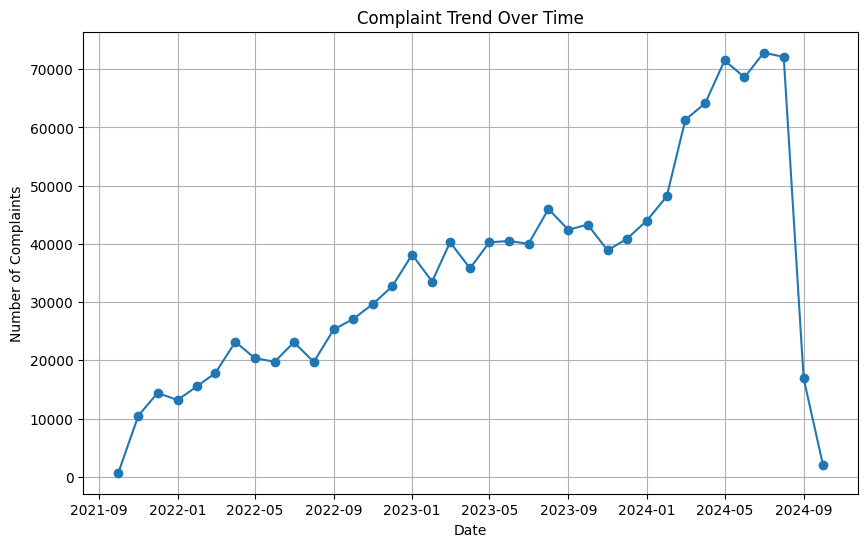

In [ ]:
from pyspark.sql.functions import year, month, count
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate complaint counts by month and year
monthly_trend_df = df.groupBy(year("date_received").alias("year"), month("date_received").alias("month")) \
                     .agg(count("*").alias("complaint_count")) \
                     .orderBy("year", "month") \
                     .toPandas()  # Convert to Pandas DataFrame for plotting

# Create a new datetime column for plotting purposes
monthly_trend_df['date'] = pd.to_datetime(monthly_trend_df[['year', 'month']].assign(day=1))

# Plot the monthly trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_trend_df['date'], monthly_trend_df['complaint_count'], marker='o')
plt.title("Complaint Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Complaints")
plt.grid(True)
plt.show()

The line graph above displays the trend of complaints over time. There is a noticeable upward trend in complaint volume over the observed period, peaking around mid-2024. This trend could suggest increasing consumer awareness, reporting behavior, or issues in the financial services sector. The sharp drop towards the end may be due to incomplete data for the latest period or a seasonal decline in complaints.

#### 3.3 Distribution of Complaints by Product
Identify how complaints are distributed across different products.

In [ ]:
spark.sql("""
    SELECT product, COUNT(*) AS product_count
    FROM complaints
    GROUP BY product
    ORDER BY product_count DESC
""").show(truncate = False)

+----------------------------------------------------------------------------+-------------+
|product                                                                     |product_count|
+----------------------------------------------------------------------------+-------------+
|Credit reporting or other personal consumer reports                         |520027       |
|Credit reporting, credit repair services, or other personal consumer reports|421746       |
|Debt collection                                                             |110267       |
|Checking or savings account                                                 |63004        |
|Credit card or prepaid card                                                 |39701        |
|Credit card                                                                 |38489        |
|Mortgage                                                                    |32093        |
|Money transfer, virtual currency, or money service                   

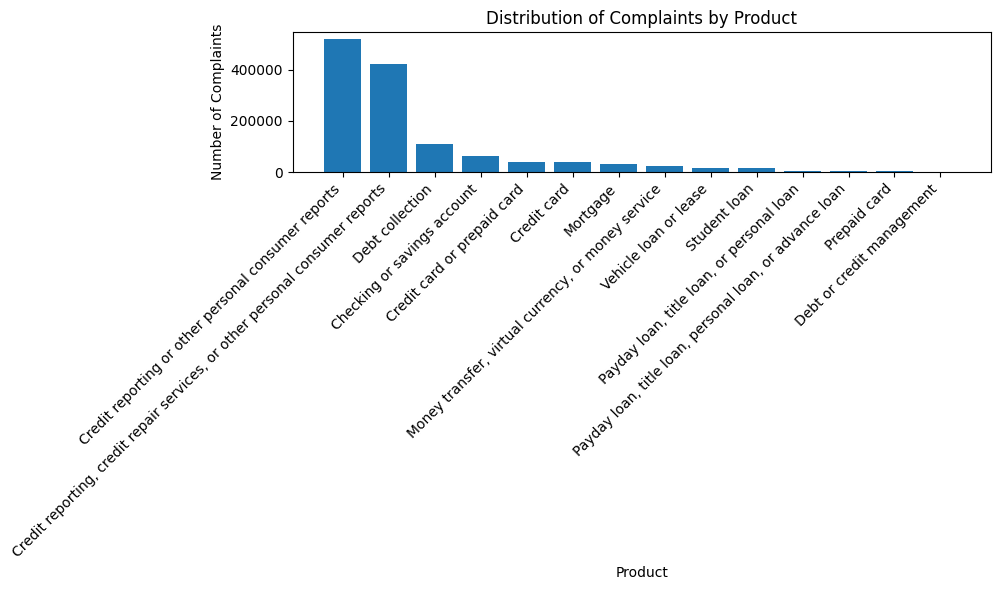

In [ ]:
# Aggregate complaint counts by Product
product_distribution_df = df.groupBy("product") \
                            .agg(count("*").alias("product_count")) \
                            .orderBy("product_count", ascending=False) \
                            .toPandas()  # Convert to Pandas DataFrame for plotting

# Plot the distribution by product
plt.figure(figsize=(10, 6))
plt.bar(product_distribution_df["product"], product_distribution_df["product_count"])
plt.title("Distribution of Complaints by Product")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The bar chart above illustrates the distribution of consumer complaints by product type. The data highlights that the majority of complaints are related to "Credit Reporting" and "Credit Repair Services," indicating significant consumer issues with these products. Other high-complaint categories include debt collection, checking or savings accounts, and credit card services. This distribution provides insight into the types of financial products that generate the most consumer dissatisfaction.

#### 3.4 Timely Response Analysis
Evaluate how often companies provide timely responses by calculating the percentage of timely responses

In [ ]:
spark.sql("""
    SELECT `timely_response`, COUNT(*) AS response_count,
           ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentage
    FROM complaints
    GROUP BY `timely_response`
""").show()

+---------------+--------------+----------+
|timely_response|response_count|percentage|
+---------------+--------------+----------+
|              1|       1286206|     99.35|
|              0|          8396|      0.65|
+---------------+--------------+----------+



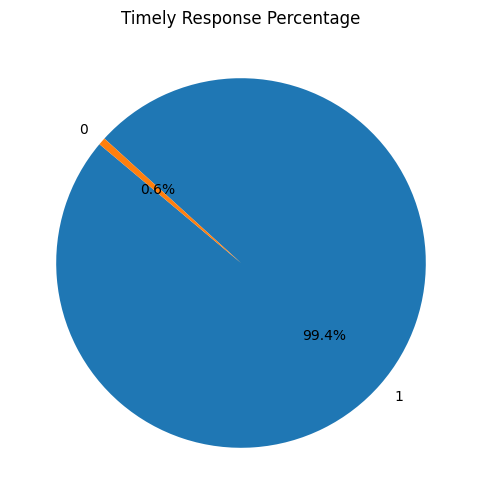

In [ ]:
# Count timely vs. untimely responses
timely_response_df = df.groupBy("timely_response") \
                       .agg(count("*").alias("response_count")) \
                       .toPandas()  # Convert to Pandas DataFrame for plotting

# Plot the timely response percentage
plt.figure(figsize=(6, 6))
plt.pie(timely_response_df["response_count"], labels=timely_response_df["timely_response"], autopct='%1.1f%%', startangle=140)
plt.title("Timely Response Percentage")
plt.show()

The pie chart above shows the percentage of complaints that received timely responses from the companies involved. A significant 99.4% of complaints received responses within a timely manner, while only 0.6% did not. This high timely response rate indicates that most companies in the financial sector are responsive to consumer complaints, adhering to regulatory standards or maintaining customer service expectations.

#### 3.5 Complaints by State
Geographic distribution of complaints, indicating areas with the highest levels of consumer dissatisfaction.

The query below lists the top 10 states with the highest number of complaints.

In [ ]:
spark.sql("""
    SELECT
        state,
        COUNT(*) AS complaint_count
    FROM complaints
    GROUP BY state
    ORDER BY complaint_count DESC
""").show(10)

+-----+---------------+
|state|complaint_count|
+-----+---------------+
|   FL|         166565|
|   TX|         155436|
|   CA|         133565|
|   GA|          97797|
|   NY|          78932|
|   IL|          65726|
|   PA|          57623|
|   NC|          48351|
|   NJ|          43362|
|   MD|          32426|
+-----+---------------+
only showing top 10 rows



**Florida (FL)** has the highest complaint count at 166,565, followed closely by **Texas (TX)** and **California (CA)**.
- These states may indicate regions where specific consumer issues are more prevalent or where there is higher engagement in filing complaints.

This analysis can guide targeted strategies to address consumer concerns in these states.

#### 3.6 Complaints by Root Cause/Issues

Find the top 10 issues reported by consumers, highlighting the most common types of complaints

In [ ]:
spark.sql("""
    SELECT
        issue,
        COUNT(*) AS complaint_count
    FROM complaints
    GROUP BY issue
    ORDER BY complaint_count DESC
    LIMIT 10
""").show(truncate=False)

+--------------------------------------------------------------------------------+---------------+
|issue                                                                           |complaint_count|
+--------------------------------------------------------------------------------+---------------+
|Incorrect information on your report                                            |396606         |
|Improper use of your report                                                     |286133         |
|Problem with a credit reporting company's investigation into an existing problem|130434         |
|Problem with a company's investigation into an existing problem                 |129563         |
|Attempts to collect debt not owed                                               |52503          |
|Managing an account                                                             |35180          |
|Written notification about debt                                                 |28237          |
|Problem w

- The most frequently reported issue is **Incorrect information on your report**, with 396,606 complaints, followed by **Improper use of your report**.
- Issues related to **credit reporting** and **investigation problems** dominate the top complaint types, indicating common areas of consumer frustration.
- Debt collection-related issues, such as **Attempts to collect debt not owed** and **Written notification about debt**, also feature prominently in the top 10.

This breakdown can help identify priority areas for improving consumer experience and addressing recurrent issues effectively.

#### 3.7 Most Common Issues and Sub Issues


Top 10 most common issues and their associated sub-issues, providing a deeper understanding of specific consumer concerns.


In [ ]:
spark.sql("""
    SELECT
        issue,
        sub_issue,
        COUNT(*) AS complaint_count
    FROM complaints
    GROUP BY issue, sub_issue
    ORDER BY complaint_count DESC
    LIMIT 10
""").show(truncate=False)

+--------------------------------------------------------------------------------+--------------------------------------------------------+---------------+
|issue                                                                           |sub_issue                                               |complaint_count|
+--------------------------------------------------------------------------------+--------------------------------------------------------+---------------+
|Incorrect information on your report                                            |Information belongs to someone else                     |237426         |
|Improper use of your report                                                     |Reporting company used your report improperly           |221565         |
|Problem with a credit reporting company's investigation into an existing problem|Their investigation did not fix an error on your report |84561          |
|Problem with a company's investigation into an existing problem

- **Incorrect information on your report** is a prevalent issue, with sub-issues such as **Information belongs to someone else** and **Account status incorrect** topping the list.
- **Improper use of your report** and investigation-related complaints also feature prominently, indicating common challenges consumers face with credit reporting and debt collection.
- Specific sub-issues, such as **Their investigation did not fix an error on your report**, highlight areas where resolution processes may need improvement.

This data provides insights that can be used to address targeted concerns within each issue category.

#### 3.8 Average Character Length & Word Count in Complaint Text

In [ ]:
spark.sql("""
    SELECT
        AVG(LENGTH(consumer_complaint_narrative)) AS avg_narrative_length,
        AVG(SIZE(SPLIT(consumer_complaint_narrative, ' '))) AS avg_word_count
    FROM complaints
    WHERE consumer_complaint_narrative IS NOT NULL
""").show()

+--------------------+------------------+
|avg_narrative_length|    avg_word_count|
+--------------------+------------------+
|   985.9831593030136|212.96503326891198|
+--------------------+------------------+



#### 3.9 Word Count & Most Frequent Words

List the ten most common words found in consumer complaints, along with their respective counts. This frequency analysis highlights recurring themes and key terms in the complaints dataset.

In [ ]:
spark.sql("""
    WITH words AS (SELECT EXPLODE(SPLIT(consumer_complaint_narrative, ' ')) AS word
            FROM complaints)
    SELECT word, COUNT(*) AS word_count
    FROM words
    WHERE LENGTH(word) > 4  -- to filter stop words
    GROUP BY word
    ORDER BY word_count DESC
    LIMIT 10
""").show()

+-----------+----------+
|       word|word_count|
+-----------+----------+
|     credit|   2036526|
|information|   1707953|
|     report|   1624775|
|   consumer|   1525733|
|    account|   1396111|
|  reporting|   1050551|
|   accounts|    703728|
|      these|    600260|
|      which|    574020|
|     agency|    543725|
+-----------+----------+



- **Credit**, **information**, and **report** are the top three most frequent words, indicating that many complaints are related to credit reporting and information accuracy.
- The high occurrence of terms such as **consumer** and **account** suggests that complaints often focus on issues related to individual accounts and consumer rights.
- Common words like **agency** may point to concerns involving credit agencies or regulatory bodies.

This word frequency analysis helps identify common topics and terms, which can guide efforts to address frequent issues in consumer complaints.

#### 3.10 Complaint Narrative Words Counts Distribution

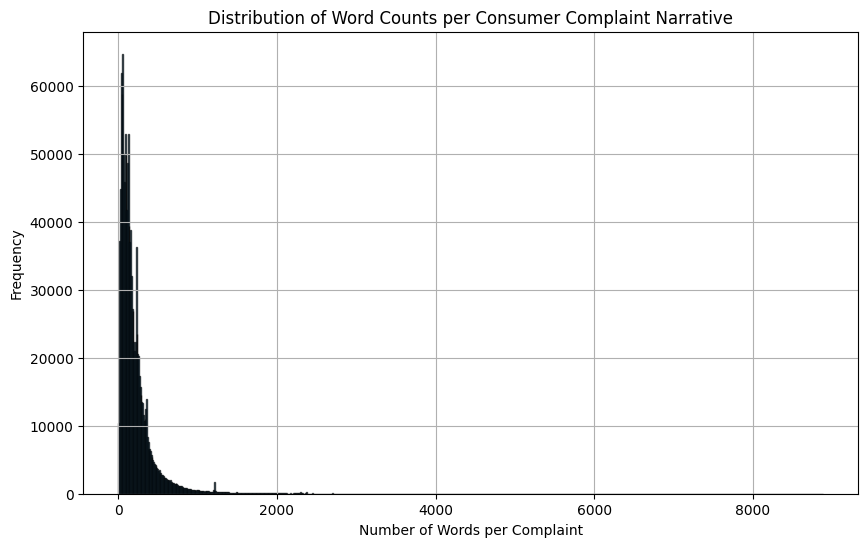

In [ ]:
import matplotlib.pyplot as plt

# SQL query to count the number of words per consumer complaint narrative
spark.sql("""
    SELECT
        LENGTH(consumer_complaint_narrative) - LENGTH(REPLACE(consumer_complaint_narrative, ' ', '')) + 1 AS word_count
    FROM complaints
    WHERE consumer_complaint_narrative IS NOT NULL
""").createOrReplaceTempView("complaint_word_counts")

# Load the result of the SQL query into a Pandas DataFrame
df_word_counts_per_narrative = spark.sql("SELECT * FROM complaint_word_counts").toPandas()

# Plot the distribution of word counts per narrative
plt.figure(figsize=(10, 6))

# Plot the histogram of word counts per narrative
plt.hist(df_word_counts_per_narrative['word_count'],
         bins=range(min(df_word_counts_per_narrative['word_count']), max(df_word_counts_per_narrative['word_count']) + 10, 10),
         edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title("Distribution of Word Counts per Consumer Complaint Narrative")
plt.xlabel("Number of Words per Complaint")
plt.ylabel("Frequency")
plt.grid(True)

# Show the plot
plt.show()


This histogram illustrates the distribution of word counts in consumer complaint narratives. Most complaints have brief narratives, with a significant concentration of narratives under 500 words. The skew towards shorter complaint descriptions suggests that consumers tend to provide concise descriptions of their issues, with fewer instances of detailed, lengthy narratives.

# 4. Data PreProcessing/Cleaning for ML

In [ ]:
from pyspark.sql.functions import lower, col
df = df.withColumn("consumer_complaint_narrative", lower(col("consumer_complaint_narrative")))

#### 4.1 Standardizing Product Cateogeries

In [ ]:
df.select("product").distinct().count()

14

In [ ]:
df.select("product").distinct().show(truncate=False)

+----------------------------------------------------------------------------+
|product                                                                     |
+----------------------------------------------------------------------------+
|Debt collection                                                             |
|Debt or credit management                                                   |
|Money transfer, virtual currency, or money service                          |
|Payday loan, title loan, personal loan, or advance loan                     |
|Checking or savings account                                                 |
|Mortgage                                                                    |
|Prepaid card                                                                |
|Credit card or prepaid card                                                 |
|Credit reporting or other personal consumer reports                         |
|Credit card                                        

There are 14 distinct product categories found. These can further be standardized into below 5 categories.

1.   Debt and Credit Management
 > - Debt collection
 > - Debt or credit management
 > - Credit reporting or other personal consumer reports
 > - Credit reporting, credit repair services, or other personal consumer reports                   
2.   Loans
> - Payday loan, title loan, personal loan, or advance loan
> - Payday loan, title loan, or personal loan
> - Student loan
> - Vehicle loan or lease
> - Mortgage
3.   Bank Accounts
> - Checking or savings account
4.   Credit and Prepaid Cards
> - Credit card
> - Prepaid card
> - Credit card or prepaid card
5.   Money Services
> - Money transfer, virtual currency, or money service

In [ ]:

# Grouping similar items under broader, standardized categories
std_df = spark.sql("""
            SELECT *,
              CASE
                WHEN product IN (
                    'Debt collection',
                    'Debt or credit management',
                    'Credit reporting or other personal consumer reports',
                    'Credit reporting, credit repair services, or other personal consumer reports'
                ) THEN 'Debt and Credit Management'
                WHEN product IN (
                    'Payday loan, title loan, personal loan, or advance loan',
                    'Payday loan, title loan, or personal loan',
                    'Student loan',
                    'Vehicle loan or lease',
                    'Mortgage'
                ) THEN 'Loans'
                WHEN product = 'Checking or savings account' THEN 'Bank Accounts'
                WHEN product IN (
                    'Credit card',
                    'Prepaid card',
                    'Credit card or prepaid card'
                ) THEN 'Credit and Prepaid Cards'
                WHEN product = 'Money transfer, virtual currency, or money service' THEN 'Money Services'
                ELSE product
            END AS std_product
        FROM consumer_complaints
 """)


# Use Spark SQL to standardize product names
# std_df = spark.sql("""
#     SELECT *,
#       CASE
#         WHEN product LIKE '%Debt%' THEN 'debt collection or management'
#         WHEN product LIKE '%Credit reporting%' OR product LIKE '%Credit repair%' THEN 'credit reporting or repair'
#         WHEN product LIKE '%Credit card%' OR product LIKE '%Prepaid%'  THEN 'credit or prepaid card'
#         WHEN product LIKE '%Money transfer%' OR product LIKE '%Virtual currency%' THEN 'money transfer or virtual currency'
#         WHEN product LIKE '%Payday loan%' OR product LIKE '%title loan%' OR product LIKE '%personal loan%' THEN 'pay day or personal loan'
#         WHEN product LIKE '%Checking%' OR product LIKE '%Savings%' THEN 'checking or savings account'
#         WHEN product LIKE '%Mortgage%' THEN 'mortgage'
#         WHEN product LIKE '%Vehicle loan%' THEN 'vehicle loan or lease'
#         WHEN product LIKE '%Student loan%' THEN 'student loan'
#         ELSE product
#       END AS std_product
#     FROM consumer_complaints
# """)

# Show the new standardized products
std_df.select("product", "std_product").distinct().show(truncate=False)

+----------------------------------------------------------------------------+--------------------------+
|product                                                                     |std_product               |
+----------------------------------------------------------------------------+--------------------------+
|Credit card                                                                 |Credit and Prepaid Cards  |
|Credit reporting or other personal consumer reports                         |Debt and Credit Management|
|Debt or credit management                                                   |Debt and Credit Management|
|Payday loan, title loan, personal loan, or advance loan                     |Loans                     |
|Debt collection                                                             |Debt and Credit Management|
|Student loan                                                                |Loans                     |
|Credit card or prepaid card                  

In [ ]:
std_df.select("std_product").distinct().count()

5

In [ ]:
std_df.groupBy('std_product').count().show(truncate=False)

+--------------------------+-------+
|std_product               |count  |
+--------------------------+-------+
|Credit and Prepaid Cards  |82121  |
|Loans                     |74217  |
|Debt and Credit Management|1053291|
|Money Services            |21969  |
|Bank Accounts             |63004  |
+--------------------------+-------+



#### 4.2 Optimize Data Types Based on Range

Print the Schema of dataframe

In [ ]:
std_df.printSchema()

root
 |-- date_received: date (nullable = true)
 |-- product: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- sub_issue: string (nullable = true)
 |-- consumer_complaint_narrative: string (nullable = true)
 |-- company: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- company_response_to_consumer: string (nullable = true)
 |-- timely_response: integer (nullable = true)
 |-- complaint_id: integer (nullable = true)
 |-- std_product: string (nullable = true)



Find minimum and maximum values for numeric columns and decide the appropriate data types accordingly

In [ ]:
# Find the min and max for numeric columns
std_df.selectExpr(
    "MIN(timely_response) as min_timely_response",
    "MAX(timely_response) as max_timely_response",
    "MIN(complaint_id) as min_complaint_id",
    "MAX(complaint_id) as max_complaint_id"
).show()

+-------------------+-------------------+----------------+----------------+
|min_timely_response|max_timely_response|min_complaint_id|max_complaint_id|
+-------------------+-------------------+----------------+----------------+
|                  0|                  1|         4855230|        10585431|
+-------------------+-------------------+----------------+----------------+



Cast columns to optimized data types


In [ ]:
std_df = std_df.withColumn("timely_response", F.col("timely_response").cast(ByteType()))
# Verify the schema after casting
std_df.printSchema()

root
 |-- date_received: date (nullable = true)
 |-- product: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- sub_issue: string (nullable = true)
 |-- consumer_complaint_narrative: string (nullable = true)
 |-- company: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- company_response_to_consumer: string (nullable = true)
 |-- timely_response: byte (nullable = true)
 |-- complaint_id: integer (nullable = true)
 |-- std_product: string (nullable = true)



In [ ]:
del df
import gc
gc.collect()

55772

Save the Optimized DataFrame

In [ ]:
!rm -rf {PROJECT_DIR}/consumer_complaints
!rm -rf /content/consumer_complaints

In [ ]:
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.
permanent_table_name = "consumer_complaints"
std_df.write.format("parquet").mode("overwrite").save(permanent_table_name)

In [ ]:
!cp -r /content/consumer_complaints {PROJECT_DIR}/consumer_complaints

In [ ]:
# !find . -iname *parquet*

In [ ]:
!ls -lrth /content/consumer_complaints

total 569M
-rw-r--r-- 1 root root 125M Nov 17 23:56 part-00003-87fdbfb3-9725-47b8-a645-400124d1d624-c000.snappy.parquet
-rw-r--r-- 1 root root 126M Nov 17 23:56 part-00001-87fdbfb3-9725-47b8-a645-400124d1d624-c000.snappy.parquet
-rw-r--r-- 1 root root 125M Nov 17 23:56 part-00002-87fdbfb3-9725-47b8-a645-400124d1d624-c000.snappy.parquet
-rw-r--r-- 1 root root 125M Nov 17 23:56 part-00000-87fdbfb3-9725-47b8-a645-400124d1d624-c000.snappy.parquet
-rw-r--r-- 1 root root  69M Nov 17 23:56 part-00004-87fdbfb3-9725-47b8-a645-400124d1d624-c000.snappy.parquet
-rw-r--r-- 1 root root    0 Nov 17 23:56 _SUCCESS


The presence of multiple part files when saving a DataFrame in PySpark is expected behavior and relates to how PySpark handles data distribution and storage:

#### 1. **Why Multiple Part Files?**
- **Distributed Computing**: PySpark runs on a distributed computing framework (e.g., Spark on Hadoop or standalone clusters), which divides the data into partitions that are processed in parallel by different worker nodes.
- **Parallel Writes**: When writing a DataFrame to a file format (e.g., Parquet, CSV), each partition writes its portion of the data as a separate file. These files are usually named as `part-00000`, `part-00001`, and so on.
- **Scalability**: This approach allows Spark to scale data writing operations across multiple nodes, making it faster and more efficient to handle large data volumes.

#### 2. **What are Part Files?**
- **Part Files**: Each `part` file is a slice of the overall DataFrame data. These files are typically in the format `part-xxxxx` where `xxxxx` is a unique identifier for each partition.
- **File Size**: The number of part files depends on the number of partitions in A DataFrame. Smaller partitions mean more part files, and larger partitions mean fewer part files.
- **Change number of partitions if Needed**: `coalesce()` or `repartition()` is used to change the number of partitions.


In many cases, leaving the part files as is can be beneficial.Being mindful of the trade-offs in performance and memory usage is essential when deciding the number of partitions. By deafult, number of paritions will be same as the available number of cores.

## 4. Machine Learning Models Implementation

#### Read the stored parquet file (If required)

In [ ]:
output_path = f"/content/drive/MyDrive/bigdata_proj_data/consumer_complaints"

# options
infer_schema = "true"  # Enables Spark to infer the data types of columns automatically
first_row_is_header = "true"  # Treats the first row as the header to capture column names

std_df = spark.read.format("parquet")\
  .option("inferSchema", infer_schema)\
  .option("header", first_row_is_header)\
  .load(output_path)

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import gc

# text Tokenization
tokenizer = Tokenizer(inputCol="consumer_complaint_narrative", outputCol="words")

# Remove Stop Words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# TF (Term Frequency) Vectorization
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)

# IDF (Inverse Document Frequency) to down-weight common words
idf = IDF(inputCol="raw_features", outputCol="features")

# Index the labels (products) as numerical categories for ML algorithms
label_indexer = StringIndexer(inputCol="std_product", outputCol="label")

# Define the reusable text transformation pipeline
text_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, label_indexer])

# Sample data without replacement
sample_df = std_df.sample(withReplacement=False, fraction=0.25, seed=2024)
# Split the data into training and test sets
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=2024)
# recollect some memory
del std_df
gc.collect()

88

In [ ]:
# Fit the text transformation pipeline only on the training data
text_model = text_pipeline.fit(train_df)
train_transformed_df = text_model.transform(train_df)
test_transformed_df = text_model.transform(test_df)

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Model Evaluator (accuracy metric)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Dictionary to store models and their accuracies
model_accuracies = {}

### Model 1: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
lr_model = lr.fit(train_transformed_df)
lr_predictions = lr_model.transform(test_transformed_df)
lr_accuracy = evaluator.evaluate(lr_predictions)
model_accuracies["Logistic Regression"] = lr_accuracy
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.9133


In [ ]:
### Model 2: Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_transformed_df)
dt_predictions = dt_model.transform(test_transformed_df)
dt_accuracy = evaluator.evaluate(dt_predictions)
model_accuracies["Decision Tree"] = dt_accuracy
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

Decision Tree Accuracy: 0.8717


In [ ]:
### Model 3: Naive Bayes Classifier
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0)
nb_model = nb.fit(train_transformed_df)
nb_predictions = nb_model.transform(test_transformed_df)
nb_accuracy = evaluator.evaluate(nb_predictions)
model_accuracies["Naive Bayes"] = nb_accuracy
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

Naive Bayes Accuracy: 0.8643


## 5. Model Evaluation and Comparision

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
print("Logistic Regression - Accuracy:", lr_accuracy, "Precision:", lr_precision, "Recall:", lr_recall, "F1 Score:", lr_f1)

# Evaluate Decision Tree
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
print("Decision Tree - Accuracy:", dt_accuracy, "Precision:", dt_precision, "Recall:", dt_recall, "F1 Score:", dt_f1)

# Evaluate the Naive Bayes
nb_accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
nb_precision = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedPrecision"})
nb_recall = evaluator.evaluate(nb_predictions, {evaluator.metricName: "weightedRecall"})
nb_f1 = evaluator.evaluate(nb_predictions, {evaluator.metricName: "f1"})
print("Naive Bayes - Accuracy:", nb_accuracy, "Precision:", nb_precision, "Recall:", nb_recall, "F1 Score:", nb_f1)


Logistic Regression - Accuracy: 0.9132801347423771 Precision: 0.9101827908224773 Recall: 0.9132801347423771 F1 Score: 0.9115066409814747
Decision Tree - Accuracy: 0.871696911811525 Precision: 0.8453413252509232 Recall: 0.871696911811525 F1 Score: 0.8517922666288231
Naive Bayes - Accuracy: 0.8642614330755564 Precision: 0.9027939179325055 Recall: 0.8642614330755565 F1 Score: 0.8768842060890347


#### Hyperparameter tunning with 3-fold CV for logisitc regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Define the Model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Create ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set the Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

# Create CrossValidator
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # 5-fold cross-validation
    parallelism=2  # Parallelism for efficiency
)

# Fit the Model
cvModel = crossval.fit(train_transformed_df)

# Retrieve Best Model
best_model = cvModel.bestModel

In [ ]:
# Create DataFrame for model metrics
evaluation_results = spark.createDataFrame([
    ("Logistic Regression", lr_accuracy, lr_precision, lr_recall, lr_f1),
    ("Decision Tree", dt_accuracy, dt_precision, dt_recall, dt_f1),
    ("Naive Bayes", nb_accuracy, nb_precision, nb_recall, nb_f1)
], ["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Show the DataFrame
evaluation_results.show(truncate=False)

+-------------------+------------------+------------------+------------------+------------------+
|Model              |Accuracy          |Precision         |Recall            |F1 Score          |
+-------------------+------------------+------------------+------------------+------------------+
|Logistic Regression|0.9132801347423771|0.9101827908224773|0.9132801347423771|0.9115066409814747|
|Decision Tree      |0.871696911811525 |0.8453413252509232|0.871696911811525 |0.8517922666288231|
|Naive Bayes        |0.8642614330755564|0.9027939179325055|0.8642614330755565|0.8768842060890347|
+-------------------+------------------+------------------+------------------+------------------+



## 6. Analysis and Insights

### Model Performance:

### Reflection on Model Choices and Performance:

#### **Why Each Model Was Chosen**:
1. **Logistic Regression**:
   - Logistic Regression is well-suited for large datasets like this one (1.2 lakh observations). It provides a baseline for classification performance with its simplicity and efficiency, even on datasets with categorical features.

2. **Decision Tree**:
   - Decision Trees are ideal for datasets with categorical variables and they handle non-linear relationships and interactions well,helping companies understand which types of complaints lead to disputes or delays.
   - Decision Trees can provide interpretable insights into which features (keywords) contribute most to outcomes like dispute resolution or company response time.

3. **Naive Bayes**:
   - Naive Bayes, particularly suitable for text-heavy datasets, is chosen due to the presence of the "Consumer complaint narrative" field. Despite its independence assumption, it can efficiently handle large, text-driven datasets, making it a strong candidate for tasks involving textual analysis or classifications based on narrative content.

---

#### **Comparison of Model Performance**:
- **Logistic Regression**:
  - **Accuracy (0.913), Precision (0.910), Recall (0.913), F1 Score (0.912)**: Its metrics demonstrate its strong predictive ability for balanced classification tasks. It handles the structured, categorical nature of the dataset well, offering high reliability and a solid baseline.
  
- **Decision Tree**:
  - **Accuracy (0.872), Precision (0.845), Recall (0.872), F1 Score (0.852)**: Decision Tree performs slightly below Logistic Regression, indicating potential overfitting or the need for hyperparameter tuning. However, its interpretability makes it a strong choice for understanding categorical variable importance.

- **Naive Bayes**:
  - **Accuracy (0.864), Precision (0.903), Recall (0.864), F1 Score (0.877)**: While slightly behind in accuracy, Naive Bayes achieves high precision. This suggests that it is effective in identifying certain classes of complaints (e.g., those with specific narrative content) but may miss more nuanced cases due to the independence assumption.

---

#### **Strengths and Weaknesses**:
1. **Logistic Regression**:
   - **Strengths**: Handles large datasets efficiently, robust against multicollinearity, and offers interpretability.
   - **Weaknesses**: Struggles with non-linear relationships or complex interactions, which might exist in this dataset.

2. **Decision Tree**:
   - **Strengths**: Captures non-linear relationships, handles categorical variables well, and is interpretable.
   - **Weaknesses**: Prone to overfitting without pruning; sensitive to small variations in the data.

3. **Naive Bayes**:
   - **Strengths**: Computationally efficient for text-heavy datasets and performs well under the independence assumption.
   - **Weaknesses**: The independence assumption often does not hold, and it may fail to capture correlations between variables.

---

#### **Best Performing Model and Justification**:
- **Logistic Regression** emerges as the best-performing model with the highest metrics across accuracy, precision, recall, and F1 score. It handles the structured data efficiently, balancing both interpretability and predictive power.
- However, the choice of the final model depends on the **business objective**:
  - If **interpretability** is critical, the Decision Tree may be more suitable for identifying complaint patterns and influencing business decisions.
  - If **text analysis** is prioritized, Naive Bayes or a more advanced text classification model like TF-IDF + Logistic Regression or an NLP-based model might outperform.

---

#### **Recommendations for Improvement**:
1. **Hyperparameter Tuning**:
   - Logistic Regression: Optimize the regularization parameter to improve generalizability.
   - Decision Tree: Implement pruning, set maximum tree depth, or consider ensemble methods like Random Forest or Gradient Boosting.
   - Naive Bayes: Experiment with feature engineering on text fields (e.g., TF-IDF) to reduce the impact of the independence assumption.

2. **Advanced Models**:
   - Consider ensemble models (e.g., Random Forest, Gradient Boosted Trees) or deep learning models like neural networks to enhance performance.
   - For text-heavy fields, explore NLP models such as BERT for feature extraction.

3. **Validation**:
   - Use cross-validation or additional subsets of data to confirm the reliability and stability of model performance.

By aligning the model choice with the dataset's complexity and business objectives, Logistic Regression is an excellent starting point, but iterative improvements and domain-specific adaptations may yield even better results.
Among the models evaluated, **Logistic Regression** performed the best with an accuracy of **91.33%,** followed by **Decision Tree (87.17%)** and **Naive Bayes (86.43%).**

Logistic Regression also achieved the **highest F1-score (0.9115)**, indicating its ability to balance precision and recall effectively. This makes it the most reliable model for predicting the target variable in your dataset.

**Unexpected Findings**: Despite the robust model performance, the Decision Tree model underperformed slightly in F1-score (0.8518), which might be due to overfitting or insufficient depth in capturing complex relationships in the data.

### Business Implications

**Strategic Insights:**
Logistic Regression’s ability to classify complaints accurately can be leveraged to automate the prioritization of consumer issues. Companies can deploy this model to predict and preemptively address complaints that are more likely to escalate. The high frequency of complaints related to "Credit Reporting" and "Debt Collection" suggests that these are critical areas requiring strategic attention.

**Operational Adjustments:**
Companies should focus on improving resolution processes for the most common issues, such as “Incorrect information on your report” and “Improper use of your report”. Addressing these areas can significantly enhance consumer trust and satisfaction.
Introducing a proactive mechanism to resolve frequently recurring sub-issues, like “Account status incorrect,” can streamline operations and reduce complaint volume.
Geographic Focus:

States like Florida, Texas, and California had the highest complaint counts. This indicates an opportunity to deploy targeted consumer education and support initiatives in these regions.

### Actionable Recommendations



*   **Product-Specific Enhancements:** For "Credit Reporting" services, consider implementing user-friendly tools for customers to verify and correct information easily. This can address a significant portion of complaints related to inaccurate reporting.

*   **Customer Support Optimization:** The analysis of timely responses shows that 99.35% of complaints received timely responses. However, further training for support staff to resolve complex issues swiftly could address the remaining 0.65% and improve overall customer satisfaction.

*   **Complaint Classification Automation:** Utilize the Logistic Regression model to classify incoming complaints into categories and assign priority levels. This would enable more efficient resource allocation and faster resolution times.

*   **Monitor Trends and Take Proactive Actions:** The upward trend in complaints over time indicates potential systemic issues in the financial sector. Regular monitoring and proactive service quality audits can mitigate future spikes in complaints.


## 7. Conclusion

This project successfully demonstrated the power of big data analytics and machine learning using PySpark and SparkML. By leveraging distributed computing, we efficiently processed and analyzed a large dataset, ensuring robust data preparation and insightful exploration. The implementation of machine learning models further illustrated the practical application of Spark's scalable architecture in addressing real-world business problems.

While the models achieved promising performance, certain limitations, such as potential feature bias and the scope of hyperparameter tuning, were identified. These provide avenues for future improvement, including exploring advanced feature engineering techniques and incorporating additional data sources for greater predictive power.


## 8. References

- Data Source:[consumerfinance](https://www.consumerfinance.gov/data-research/consumer-complaints/search/?date_received_max=2024-08-06&date_received_min=2024-07-29&has_narrative=true&page=1&searchField=all&size=25&sort=created_date_desc&tab=List)
